In [32]:
from functools import total_ordering

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram, linkage

from src.features.encodings import kmer, ncp, multiple, pstnpss
from src.dataset import load_benchmark_dataset, Species, Modification

In [60]:
test_dataset = load_benchmark_dataset(Species.human, Modification.psi, True)
train_dataset = load_benchmark_dataset(Species.human, Modification.psi)

encoder = multiple.Encoder([
    # kmer.Encoder(k=4, upto=True),
    pstnpss.Encoder(),
    ncp.Encoder(),
])

# train_dataset._samples = encoder.fit_transform(train_dataset.samples, y=train_dataset.targets)
# test_dataset._samples = encoder.transform(test_dataset.samples)

test_samples = test_dataset.samples.values
train_samples = train_dataset.samples.values

test_pos_samples = test_dataset.samples[test_dataset.targets == 1].values
test_neg_samples = test_dataset.samples[test_dataset.targets == 0].values

train_pos_samples = train_dataset.samples[train_dataset.targets == 1].values
train_neg_samples = train_dataset.samples[train_dataset.targets == 0].values

In [6]:
hamming_sim = 1 - squareform(pdist(train_samples, metric='hamming'))
euclidean_sim = 1 / (1 + squareform(pdist(train_samples, metric='euclidean')))
cosine_sim = cosine_similarity(train_samples)

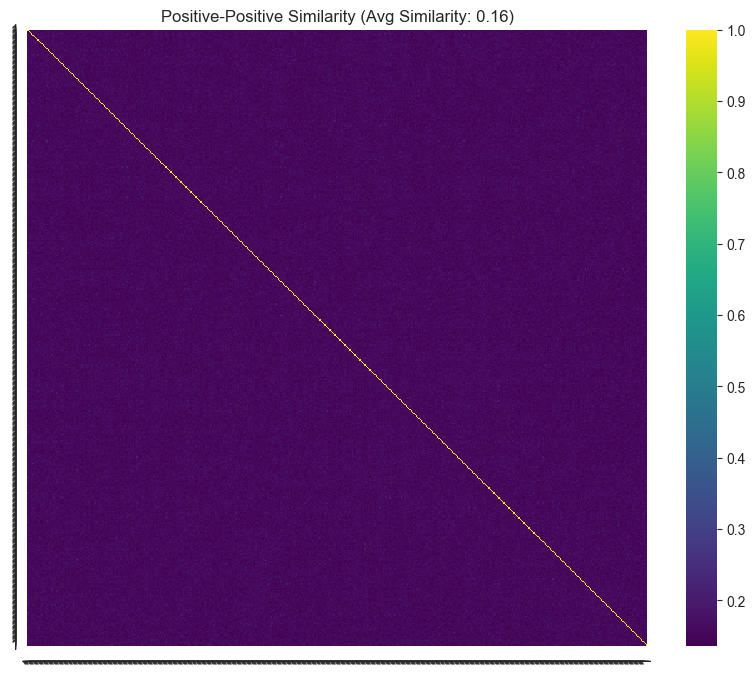

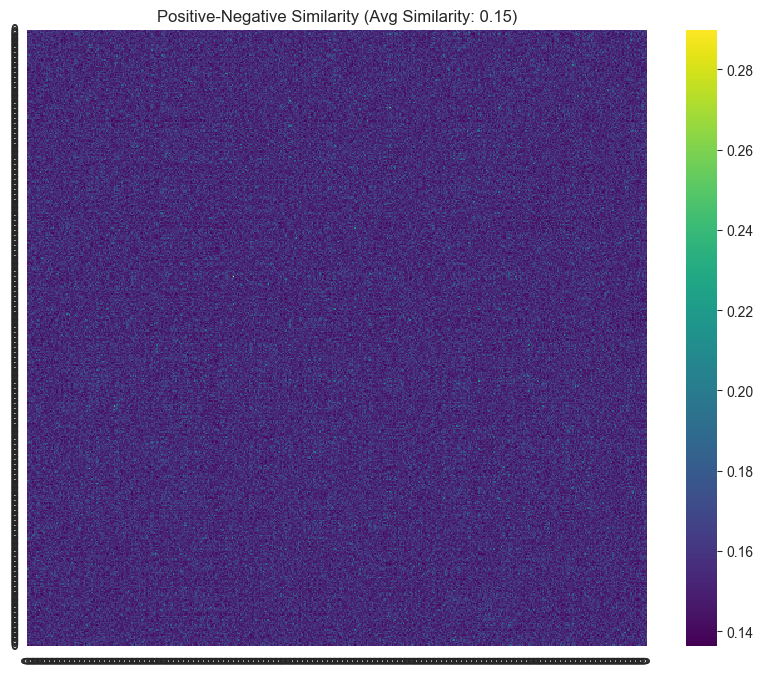

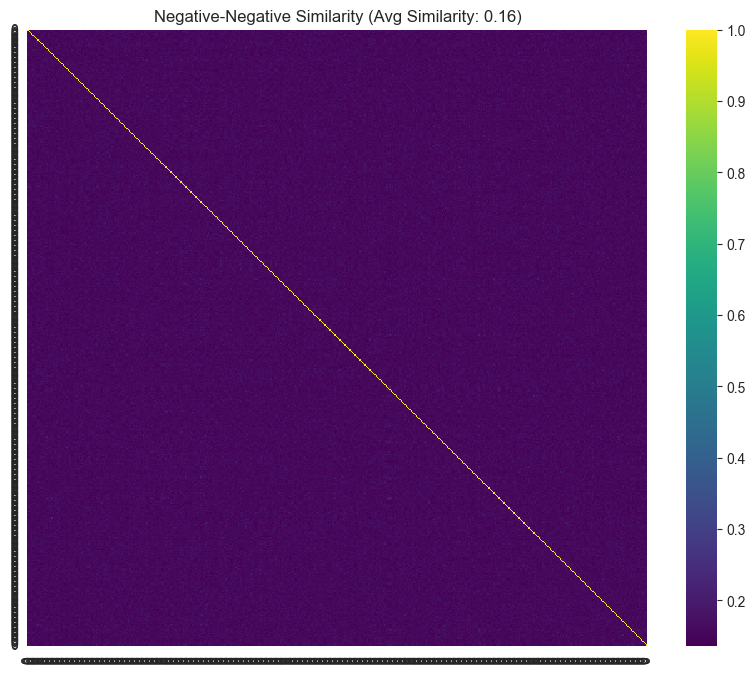

In [8]:
def plot_heatmap(matrix, labels, title, avg_similarity):
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, xticklabels=labels, yticklabels=labels, cmap='viridis')
    plt.title(f"{title} (Avg Similarity: {avg_similarity:.2f})")
    plt.show()


def average_similarity(matrix):
    return np.mean([(np.sum(x) - 1) / len(x) for x in matrix])


# Create heatmaps for each comparison
pos_indices = [i for i, label in enumerate(train_dataset.targets) if label == 1]
neg_indices = [i for i, label in enumerate(train_dataset.targets) if label == 0]

# Positive-Positive
pos_pos_sim = euclidean_sim[np.ix_(pos_indices, pos_indices)]
avg_pos_pos = average_similarity(pos_pos_sim)
plot_heatmap(pos_pos_sim, [train_dataset.targets[i] for i in pos_indices], 'Positive-Positive Similarity', avg_pos_pos)

# Positive-Negative
pos_neg_sim = euclidean_sim[np.ix_(pos_indices, neg_indices)]
avg_pos_neg = average_similarity(pos_neg_sim)
plot_heatmap(pos_neg_sim, [train_dataset.targets[i] for i in neg_indices], 'Positive-Negative Similarity', avg_pos_neg)

# Negative-Negative
neg_neg_sim = euclidean_sim[np.ix_(neg_indices, neg_indices)]
avg_neg_neg = average_similarity(neg_neg_sim)
plot_heatmap(neg_neg_sim, [train_dataset.targets[i] for i in neg_indices], 'Negative-Negative Similarity', avg_neg_neg)

In [30]:
import RNA

# import RNA
# import subprocess
# import os
# 
# def visualize_rna_structure(sequence, output_file="rna_structure.png"):
#     # Fold the RNA sequence
#     (ss, mfe) = RNA.fold(sequence)
#     print(f"Predicted structure: {ss}")
#     print(f"Minimum free energy: {mfe}")
# 
#     # Create a temporary PostScript file
#     ps_file = "rna_structure.ps"
#     
#     # Use RNA.PS_rna_plot to generate a PostScript file
#     RNA.PS_rna_plot(sequence, ss, ps_file)
# 
#     # Convert PostScript to PNG using ImageMagick
#     # try:
#         # subprocess.run(["convert", ps_file, output_file], check=True)
#         # print(f"Structure visualization saved as {output_file}")
#     # except Exception as e:
#     #     print(e)
# 
#     # Clean up the temporary PS file
#     # os.remove(ps_file)
# 
# # Example usage
# sequence = "CAUGGAGAGAPGUUCUUUACU"
# visualize_rna_structure(sequence)
# 
# # ..((((((.....))))))..
# # ......(((...)))......

In [91]:
positive_sequences = []
for sample in test_pos_samples:
    S1 = sample[0]
    s1, c1 = RNA.fold(S1)

    S2 = S1[: len(S1) // 2] + 'P' + S1[len(S1) // 2 + 1:]
    s2, c2 = RNA.fold(S2)

    if s1 != s2:
        positive_sequences.append(S1)

In [90]:
len(positive_sequences)

16

In [92]:
negative_sequences = []
for sample in test_neg_samples:
    S1 = sample[0]
    s1, c1 = RNA.fold(S1)

    S2 = S1[: len(S1) // 2] + 'P' + S1[len(S1) // 2 + 1:]
    s2, c2 = RNA.fold(S2)

    if s1 != s2:
        negative_sequences.append(S1)

In [93]:
positive_sequences

['AAACUAUCGCUUCUCGGCCUU',
 'UCGGGCCUAGUUCAAACCUUU',
 'AGCCAUCAGGUAAGCCAAGAU',
 'UAGCUAUCGCUUCUCGGCCUU',
 'GUAGUAUCUGUUCUUAUCAGU',
 'UGUUUUUGUAUUGUUGCUCCU',
 'UAAGUUAUUUUGCUCUCACUG',
 'CCAUUAUCGCUUCUCGGCCUU',
 'GUAAAAGGGUUACUCUCAUAC',
 'UAAGUUAUUUUGCUCUCACUG']

In [94]:
negative_sequences

['CAGCUGGGAGUUAAAUACUCU',
 'UCUUAACUCUUGGGGCUGGUA',
 'UAGGGUCGCCUUAAGUCAACA',
 'CACCAUGGUGUCUGGGAGCAC',
 'GACCAUGUCUUGAAAAGACAA',
 'UCCUGAGAGUUCACGCUGAGC',
 'AUGGAAAUCCUUUUGUUUUGU',
 'GUGGAACCUCUCUAGUUAAAA',
 'GGCUCCAGGAUCCUAAGGGAC',
 'GACCUAACUUUGGAUACUUUU',
 'UGGAAGUCUUUUCCUUUAAAG',
 'CACAAUUGCAUGUGGAAGCUG',
 'GGACCCCACCUAAAAGUAUAA',
 'GAUGAAUGCUUUCUCAAAAGU',
 'UCACAGAUGCUCCAGCAGGCA',
 'GUCAGGAGGCUGUCUUACGUA']

In [95]:
import random

sub_samples = positive_sequences + negative_sequences
sub_targets = [1 for _ in positive_sequences] + [0 for _ in negative_sequences]

temp = list(zip(sub_samples, sub_targets))
random.shuffle(temp)

res1, res2 = zip(*temp)
res1, res2 = list(res1), list(res2)

In [96]:
from pandas import DataFrame
from src.features.encodings import binary
sub_samples_df = DataFrame(res1, columns=[0])

encoder = binary.Encoder()
encoded_data = encoder.fit_transform(sub_samples_df)

In [80]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

In [81]:
model = SVC()
model.fit(encoded_data, sub_targets)

SVC()

In [97]:
print(classification_report(sub_targets, model.predict(encoded_data)))

              precision    recall  f1-score   support

           0       0.50      0.25      0.33        16
           1       0.33      0.60      0.43        10

    accuracy                           0.38        26
   macro avg       0.42      0.42      0.38        26
weighted avg       0.44      0.38      0.37        26



In [86]:
print(classification_report(test_dataset.targets, model.predict(encoder.transform(test_dataset.samples))))

              precision    recall  f1-score   support

           0       0.58      0.34      0.43       100
           1       0.53      0.75      0.62       100

    accuracy                           0.55       200
   macro avg       0.55      0.55      0.53       200
weighted avg       0.55      0.55      0.53       200

